In [1]:
# Dependencies
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import openweathermapy.core as owm
from citipy import citipy
from urllib.error import HTTPError
import gmplot
import time
import os

os.environ['PROJ_LIB'] = r'C:\Anaconda\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

from mpl_toolkits.basemap import Basemap

# Read crime data file   

In [44]:
file='NYPD_Data.csv'
df=pd.read_csv(file)
df.head()
# convert CMPLNT_FR_DT to date format. 222398 rows records in file
df['CMPLNT_FR_DT'] = pd.to_datetime(df['CMPLNT_FR_DT'],errors = 'coerce') 
df

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,857927015,10.0,MANHATTAN,2019-01-29,16:37:00,1/29/2019,16:45:00,COMPLETED,NaN,NaN,...,M,NaN,UNKNOWN,UNKNOWN,M,984140.0,211709.0,40.747777,-74.000398,"(40.747777093, -74.000398443)"
1,479254687,101.0,QUEENS,2019-03-29,17:00:00,3/29/2019,17:10:00,COMPLETED,NaN,NaN,...,M,NaN,25-44,BLACK,F,1054076.0,157437.0,40.598538,-73.748560,"(40.598537593, -73.748559596)"
2,320007604,41.0,BRONX,2019-02-06,2:00:00,NaN,NaN,COMPLETED,NaN,NaN,...,M,NaN,UNKNOWN,UNKNOWN,D,1011589.0,237996.0,40.819886,-73.901227,"(40.819885621, -73.901226998)"
3,746022144,68.0,BROOKLYN,2019-01-08,22:49:00,1/8/2019,22:52:00,COMPLETED,NaN,NaN,...,M,NaN,UNKNOWN,UNKNOWN,E,984439.0,166855.0,40.624663,-73.999321,"(40.624663129, -73.999320591)"
4,145366108,25.0,MANHATTAN,2019-02-11,12:07:00,NaN,NaN,COMPLETED,NaN,NaN,...,NaN,NaN,UNKNOWN,UNKNOWN,E,1002776.0,231994.0,40.803435,-73.933084,"(40.80343468, -73.93308448)"
5,889702556,32.0,MANHATTAN,2019-03-11,21:40:00,NaN,NaN,COMPLETED,NaN,NaN,...,M,NaN,45-64,BLACK,F,999283.0,235265.0,40.812419,-73.945694,"(40.812419303, -73.945694068)"
6,291569019,50.0,BRONX,2019-02-16,17:15:00,NaN,NaN,COMPLETED,NaN,NaN,...,M,NaN,45-64,BLACK,M,1011244.0,256820.0,40.871553,-73.902398,"(40.871553006, -73.902397688)"
7,811464670,73.0,BROOKLYN,2019-02-09,20:36:00,NaN,NaN,COMPLETED,NaN,NaN,...,NaN,NaN,45-64,UNKNOWN,F,1009192.0,182352.0,40.667164,-73.910094,"(40.667163928, -73.910093567)"
8,605345964,46.0,BRONX,2019-03-14,18:20:00,NaN,NaN,COMPLETED,NaN,NaN,...,NaN,NaN,UNKNOWN,UNKNOWN,E,1011923.0,250786.0,40.854989,-73.899968,"(40.854989406, -73.899967505)"
9,816741975,18.0,MANHATTAN,2019-03-30,14:58:00,NaN,NaN,COMPLETED,NaN,NaN,...,F,NaN,UNKNOWN,UNKNOWN,D,991531.0,217373.0,40.763320,-73.973718,"(40.763320339, -73.973717904)"


In [12]:
# Filter for only "Felony" category
felonyDf = df[df["LAW_CAT_CD"] == 'FELONY'] 
felonyDf=felonyDf.reset_index(drop=True)
# Drop rows if CMPLNT_FR_DT does not have any value
felonyDf=felonyDf.dropna(subset = ['CMPLNT_FR_DT'])
# Limit our analysis to last 10 years - 2010 to 2019
felonyDf = felonyDf[(felonyDf['CMPLNT_FR_DT'] > '2010-01-01') & (felonyDf['CMPLNT_FR_DT'] <= '2019-09-06')]
# create new columns to store year and month to enable aggregration
felonyDf['CMPLNT_YR']=pd.DatetimeIndex(felonyDf['CMPLNT_FR_DT']).year
felonyDf['CMPLNT_Month']=pd.DatetimeIndex(felonyDf['CMPLNT_FR_DT']).month
#felonyDf.to_csv('felonyfull.csv')

felonyDf

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,CMPLNT_YR,CMPLNT_Month
0,857927015,10.0,MANHATTAN,2019-01-29,16:37:00,1/29/2019,16:45:00,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,M,984140.0,211709.0,40.747777,-74.000398,"(40.747777093, -74.000398443)",2019,1
1,479254687,101.0,QUEENS,2019-03-29,17:00:00,3/29/2019,17:10:00,COMPLETED,NaN,NaN,...,25-44,BLACK,F,1054076.0,157437.0,40.598538,-73.748560,"(40.598537593, -73.748559596)",2019,3
2,320007604,41.0,BRONX,2019-02-06,2:00:00,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,D,1011589.0,237996.0,40.819886,-73.901227,"(40.819885621, -73.901226998)",2019,2
3,746022144,68.0,BROOKLYN,2019-01-08,22:49:00,1/8/2019,22:52:00,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,E,984439.0,166855.0,40.624663,-73.999321,"(40.624663129, -73.999320591)",2019,1
4,889702556,32.0,MANHATTAN,2019-03-11,21:40:00,NaN,NaN,COMPLETED,NaN,NaN,...,45-64,BLACK,F,999283.0,235265.0,40.812419,-73.945694,"(40.812419303, -73.945694068)",2019,3
5,811464670,73.0,BROOKLYN,2019-02-09,20:36:00,NaN,NaN,COMPLETED,NaN,NaN,...,45-64,UNKNOWN,F,1009192.0,182352.0,40.667164,-73.910094,"(40.667163928, -73.910093567)",2019,2
6,605345964,46.0,BRONX,2019-03-14,18:20:00,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,E,1011923.0,250786.0,40.854989,-73.899968,"(40.854989406, -73.899967505)",2019,3
7,816741975,18.0,MANHATTAN,2019-03-30,14:58:00,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,D,991531.0,217373.0,40.763320,-73.973718,"(40.763320339, -73.973717904)",2019,3
8,403194332,113.0,QUEENS,2019-03-17,15:53:00,3/17/2019,16:07:00,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,E,1048111.0,188479.0,40.683786,-73.769745,"(40.68378593, -73.769745503)",2019,3
9,530663781,44.0,BRONX,2019-03-02,7:19:00,NaN,NaN,COMPLETED,NaN,NaN,...,18-24,BLACK,M,1006999.0,245897.0,40.841585,-73.917784,"(40.841584606, -73.917783638)",2019,3


In [13]:
# Summary of felonies for the last 10 years
felonySummary=felonyDf.groupby(['CMPLNT_YR','OFNS_DESC']).agg({'OFNS_DESC':'count'})
felonySummary=felonySummary.rename(columns={'OFNS_DESC':"Total Count"})
# Sort by total offsense count to see the top 5 categories
felonySummary=felonySummary.sort_values('Total Count',ascending=False)
felonySummary.reset_index()

,CMPLNT_YR,OFNS_DESC,Total Count
0,2019,GRAND LARCENY,18012
1,2019,FELONY ASSAULT,9680
2,2019,MISCELLANEOUS PENAL LAW,6620
3,2019,ROBBERY,5789
4,2019,CRIMINAL MISCHIEF & RELATED OF,5168
5,2019,BURGLARY,4712
6,2019,FORGERY,2594
7,2019,DANGEROUS WEAPONS,2333
8,2019,DANGEROUS DRUGS,2283
9,2019,GRAND LARCENY OF MOTOR VEHICLE,2084


In [45]:
# Limit our analysis to the top 5 offense categories , we end up with 47755 rows for our analysis
felony5 = felonyDf[(felonyDf['OFNS_DESC'] == 'GRAND LARCENY') | (felonyDf['OFNS_DESC'] == 'FELONY ASSAULT') | (felonyDf['OFNS_DESC'] == 'MISCELLANEOUS PENAL LAW') | (felonyDf['OFNS_DESC'] == 'ROBBERY') | (felonyDf['OFNS_DESC'] == 'CRIMINAL MISCHIEF & RELATED OF')]
felony5

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,CMPLNT_YR,CMPLNT_Month
0,857927015,10.0,MANHATTAN,2019-01-29,16:37:00,1/29/2019,16:45:00,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,M,984140.0,211709.0,40.747777,-74.000398,"(40.747777093, -74.000398443)",2019,1
2,320007604,41.0,BRONX,2019-02-06,2:00:00,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,D,1011589.0,237996.0,40.819886,-73.901227,"(40.819885621, -73.901226998)",2019,2
4,889702556,32.0,MANHATTAN,2019-03-11,21:40:00,NaN,NaN,COMPLETED,NaN,NaN,...,45-64,BLACK,F,999283.0,235265.0,40.812419,-73.945694,"(40.812419303, -73.945694068)",2019,3
7,816741975,18.0,MANHATTAN,2019-03-30,14:58:00,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,D,991531.0,217373.0,40.763320,-73.973718,"(40.763320339, -73.973717904)",2019,3
9,530663781,44.0,BRONX,2019-03-02,7:19:00,NaN,NaN,COMPLETED,NaN,NaN,...,18-24,BLACK,M,1006999.0,245897.0,40.841585,-73.917784,"(40.841584606, -73.917783638)",2019,3
11,445955216,20.0,MANHATTAN,2019-01-02,11:30:00,NaN,NaN,COMPLETED,NaN,NaN,...,45-64,WHITE,M,991887.0,225692.0,40.786154,-73.972423,"(40.786153515, -73.972423332)",2019,1
13,158714872,46.0,BRONX,2019-03-08,12:15:00,3/8/2019,12:30:00,COMPLETED,NaN,NaN,...,45-64,BLACK,M,1010352.0,247469.0,40.845890,-73.905659,"(40.84589001, -73.905659355)",2019,3
17,257254539,73.0,BROOKLYN,2019-02-27,22:15:00,NaN,NaN,COMPLETED,NaN,NaN,...,25-44,BLACK,F,1008609.0,178434.0,40.656412,-73.912209,"(40.65641151, -73.912209246)",2019,2
18,776900920,44.0,BRONX,2019-01-08,10:35:00,NaN,NaN,COMPLETED,NaN,NaN,...,18-24,WHITE HISPANIC,M,1006071.0,240366.0,40.826406,-73.921156,"(40.826405951, -73.92115554)",2019,1
23,830941168,23.0,MANHATTAN,2019-01-09,17:06:00,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,E,1001491.0,228127.0,40.792823,-73.937736,"(40.792823419, -73.9377359)",2019,1


In [46]:

# Group by CMPLNT_YR','OFNS_DESC to see aggregation for the top 5 offenses
felony5Summary=felony5.groupby(['CMPLNT_YR','OFNS_DESC']).agg({'OFNS_DESC':'count'})
felony5Summary=felony5Summary.rename(columns={'OFNS_DESC':"Total Count"})

felony5Summary=felony5Summary.sort_values('Total Count',ascending=False)
felony5Summary=felony5Summary.reset_index()
felony5Summary


,CMPLNT_YR,OFNS_DESC,Total Count
0,2019,GRAND LARCENY,18012
1,2019,FELONY ASSAULT,9680
2,2019,MISCELLANEOUS PENAL LAW,6620
3,2019,ROBBERY,5789
4,2019,CRIMINAL MISCHIEF & RELATED OF,5168
5,2018,GRAND LARCENY,1613
6,2018,CRIMINAL MISCHIEF & RELATED OF,328
7,2018,MISCELLANEOUS PENAL LAW,174
8,2017,GRAND LARCENY,106
9,2018,FELONY ASSAULT,106


In [33]:
# Minor Data Munging to Re-Format the Data Frames
felony5pivot=felony5Summary.pivot(index='CMPLNT_YR',columns='OFNS_DESC', values='Total Count')
# Preview the Data Frame
felony5pivot=felony5pivot.reset_index()
felony5pivot=felony5pivot.fillna(0)
felony5pivot
#DataFrame.fillna()

OFNS_DESC,CMPLNT_YR,CRIMINAL MISCHIEF & RELATED OF,FELONY ASSAULT,GRAND LARCENY,MISCELLANEOUS PENAL LAW,ROBBERY
0,2010,0.0,2.0,3.0,0.0,0.0
1,2011,1.0,0.0,2.0,0.0,2.0
2,2012,0.0,0.0,6.0,0.0,0.0
3,2013,1.0,0.0,9.0,0.0,0.0
4,2014,1.0,1.0,9.0,1.0,0.0
5,2015,0.0,2.0,26.0,1.0,0.0
6,2016,0.0,5.0,27.0,3.0,2.0
7,2017,14.0,4.0,106.0,6.0,0.0
8,2018,328.0,106.0,1613.0,174.0,31.0
9,2019,5168.0,9680.0,18012.0,6620.0,5789.0


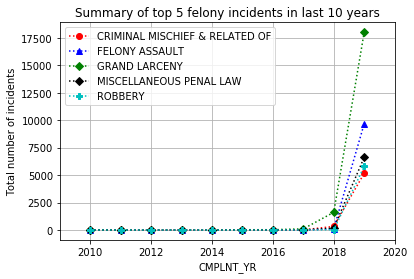

In [39]:
# Draw a line plot
ax = felony5pivot.plot( x="CMPLNT_YR",y="CRIMINAL MISCHIEF & RELATED OF", color="r", label="CRIMINAL MISCHIEF & RELATED OF",linestyle=':',marker='o')
felony5pivot.plot(x="CMPLNT_YR",y="FELONY ASSAULT", color="b", label="FELONY ASSAULT",linestyle=':',marker='^', ax=ax)
felony5pivot.plot(x="CMPLNT_YR",y="GRAND LARCENY", color="g", label="GRAND LARCENY",linestyle=':',marker='D', ax=ax)
felony5pivot.plot(x="CMPLNT_YR",y="MISCELLANEOUS PENAL LAW", color="k", label="MISCELLANEOUS PENAL LAW", linestyle=':',marker='D',ax=ax)
felony5pivot.plot(x="CMPLNT_YR",y="ROBBERY", color="c", label="ROBBERY", linestyle=':',marker='P',ax=ax)

plt.grid()
plt.xlim(2009,2020)
plt.title("Summary of top 5 felony incidents in last 10 years")
#plt.xlabel("Time (Days)")
plt.ylabel("Total number of incidents")
plt.legend()
plt.show()

In [47]:
#Create Bins to categorzie crime times
bins=[0,4,8,12,16,20,24]
Groups=['MidNight','EarlyMor','Morning','Noon','Evening','Night']
felony5['CMPLNT_FR_TM'] = pd.to_datetime(felony5['CMPLNT_FR_TM']).dt.hour

#felonyDf['CMPLNT_FR_TM'] =felonyDf['CMPLNT_FR_TM'].astype(float)
#felonyDf["CrimeTimes"] = pd.cut(df["CMPLNT_FR_TM"], bins, labels=Groups)
#felonyDf

C:\Anaconda\envs\pythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [48]:
felony5["CrimeTimes"] = pd.cut(felony5["CMPLNT_FR_TM"], bins, labels=Groups)
felony5

C:\Anaconda\envs\pythonData\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,CMPLNT_YR,CMPLNT_Month,CrimeTimes
0,857927015,10.0,MANHATTAN,2019-01-29,16,1/29/2019,16:45:00,COMPLETED,NaN,NaN,...,UNKNOWN,M,984140.0,211709.0,40.747777,-74.000398,"(40.747777093, -74.000398443)",2019,1,Noon
2,320007604,41.0,BRONX,2019-02-06,2,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,D,1011589.0,237996.0,40.819886,-73.901227,"(40.819885621, -73.901226998)",2019,2,MidNight
4,889702556,32.0,MANHATTAN,2019-03-11,21,NaN,NaN,COMPLETED,NaN,NaN,...,BLACK,F,999283.0,235265.0,40.812419,-73.945694,"(40.812419303, -73.945694068)",2019,3,Night
7,816741975,18.0,MANHATTAN,2019-03-30,14,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,D,991531.0,217373.0,40.763320,-73.973718,"(40.763320339, -73.973717904)",2019,3,Noon
9,530663781,44.0,BRONX,2019-03-02,7,NaN,NaN,COMPLETED,NaN,NaN,...,BLACK,M,1006999.0,245897.0,40.841585,-73.917784,"(40.841584606, -73.917783638)",2019,3,EarlyMor
11,445955216,20.0,MANHATTAN,2019-01-02,11,NaN,NaN,COMPLETED,NaN,NaN,...,WHITE,M,991887.0,225692.0,40.786154,-73.972423,"(40.786153515, -73.972423332)",2019,1,Morning
13,158714872,46.0,BRONX,2019-03-08,12,3/8/2019,12:30:00,COMPLETED,NaN,NaN,...,BLACK,M,1010352.0,247469.0,40.845890,-73.905659,"(40.84589001, -73.905659355)",2019,3,Morning
17,257254539,73.0,BROOKLYN,2019-02-27,22,NaN,NaN,COMPLETED,NaN,NaN,...,BLACK,F,1008609.0,178434.0,40.656412,-73.912209,"(40.65641151, -73.912209246)",2019,2,Night
18,776900920,44.0,BRONX,2019-01-08,10,NaN,NaN,COMPLETED,NaN,NaN,...,WHITE HISPANIC,M,1006071.0,240366.0,40.826406,-73.921156,"(40.826405951, -73.92115554)",2019,1,Morning
23,830941168,23.0,MANHATTAN,2019-01-09,17,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,E,1001491.0,228127.0,40.792823,-73.937736,"(40.792823419, -73.9377359)",2019,1,Evening


C:\Anaconda\envs\pythonData\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Anaconda\envs\pythonData\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Anaconda\envs\pythonData\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


TypeError: input must be an array, list, tuple or scalar

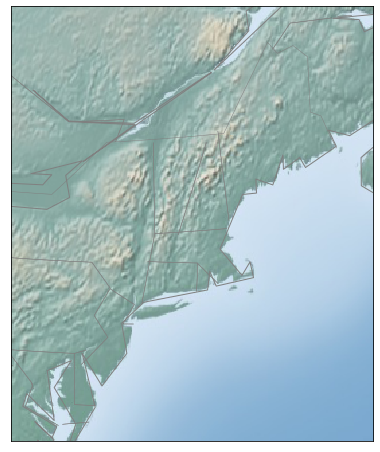

In [49]:
latitudes = felonyDf["Latitude"]
longitudes = felonyDf["Longitude"]
# Creating the location we would like to initialize the focus on. 
# Parameters: Lattitude, Longitude, Zoom
gmap = gmplot.GoogleMapPlotter(40.7128, 74.0060, 10)
#40.7128° N, 74.0060°

# Overlay our datapoints onto the map
gmap.heatmap(latitudes, longitudes)

# Generate the heatmap into an HTML file
gmap.draw("my_heatmap.html")

fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='c', 
            lat_0=43, lon_0=-72,
            width=1E6, height=1.2E6)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.scatter(latitudes, longitudes, latlon=True,cmap='Reds', alpha=0.5)

In [ ]:
plt.imshow(felonyDf,cmap='hot',interpolation='nearest')
plt.show()

In [ ]:
df2=felonyDf.groupby(['BORO_NM','OFNS_DESC']).agg({'OFNS_DESC':'count'})

#df2.columns = df2.columns.droplevel()
#felonyDf.groupby(['BORO_NM','SUSP_AGE_GROUP']).agg({'OFNS_DESC':'count'})

In [ ]:
file1='scores.csv'
eduDf=pd.read_csv(file1)
eduDf.head()